# VegET Testing: ipygee

Imports

In [1]:
import datetime
import dateutil.parser
import VegET
from VegET import interpolate, daily_aggregate, utils, veg_et_model
#import cartoee as cee
import matplotlib.pyplot as plt
# import bqplot
import ipyleaflet
import IPython.display
import numpy as np
import pandas as pd
# import traitlets
import ee
# import ipywidgets as widgets
# import ipyleaflet  # an interactive mapping "widget"
# from sidecar import Sidecar
from ipygee import *

Initialize EarthEngine

In [2]:
ee.Initialize()

Define date range

In [43]:
start_date = ee.Date('2003-04-03')
end_date = ee.Date('2003-10-28')   # to account for buffer in DOY calculations
start_year = 2003
end_year = 2018

Define ROI 

In [44]:
# ROI
roi_fc = ee.FeatureCollection('EPA/Ecoregions/2013/L4');
polygon = roi_fc.filter(ee.Filter.eq('system:index', '00000a53e3e196f3200c'))

# Filter to only include images within the colorado and utah boundaries (from ee-api/python examples)
# polygon = ee.Geometry.Polygon([[
#     [-109.05, 37.0], [-102.05, 37.0], [-102.05, 41.0],   # colorado
#     [-109.05, 41.0], [-111.05, 41.0], [-111.05, 42.0],   # utah
#     [-114.05, 42.0], [-114.05, 37.0], [-109.05, 37.0]]])

Define growing season months as integers. Note, filtering is inclusive.

In [45]:
g_season_begin = 4  # inclusive
g_season_end = 10   # inclusive

**NOTE**: for this case, the imagecollections are global or continent wide rasters. Ordinarily, the
imageCollections would need `.filterBounds()` to the ROI to subset to the images that intersect the
polygon. In this case, the filter does nothing since the images are continent/global scale.

Get ImageCollection used to calculate NDVI values. In this example, MODIS data are used.

In [46]:
ndvi_coll = ee.ImageCollection("MODIS/006/MOD09Q1").filterDate(start_date, end_date)\
    .filter(ee.Filter.calendarRange(g_season_begin, g_season_end, 'month'))\
    .map(lambda f: f.clip(polygon))
ndvi_coll = ndvi_coll.map(VegET.utils.getNDVI)

Get daily climate data (precip, eto, temp)

In [47]:
precip_eto_coll = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').filterDate(start_date, end_date)\
    .select('pr', 'eto', 'tmmn', 'tmmx').filter(ee.Filter.calendarRange(g_season_begin, g_season_end, 'month'))\
    .map(lambda f: f.clip(polygon))

# Add band for calculated mean daily temp
precip_eto_coll = precip_eto_coll.map(VegET.utils.dailyMeanTemp)
# Convert to Celsius
precip_eto_coll = precip_eto_coll.map(VegET.utils.kelvin2celsius).select(['pr', 'eto', 'tminC', 'tmaxC', 'tmeanC'])

VegET static inputs

In [48]:
# Specify canopy intercept image or imageCollection. NOTE: Assumes single band image
canopy_int = ee.Image('users/darin_EE/VegET/Interception').clip(polygon).double().rename('intercept')
# Get static Soil Water Holding Capacity grid (manually uploaded as GEE asset)
whc = ee.Image('users/darin_EE/VegET/WaterHoldingCapacity_mm').clip(polygon).double().rename('whc')
# Get static Soil Saturation image
soil_sat = ee.Image('users/darin_EE/VegET/SoilSaturation_mm').clip(polygon).double().rename('soil_sat')
# Get static Field Capacity image
fcap = ee.Image('users/darin_EE/VegET/FieldCapacity_mm').clip(polygon).double().rename('fcap')

# Create single static image with static inputs as bands
staticImage = canopy_int.addBands([whc, soil_sat, fcap])

Add static data to ndvi_coll as bands

In [49]:
ndvi_coll = ndvi_coll.map(VegET.utils.addStaticBands([staticImage]))

Daily interpolation. Primarily using methods developed in OpenET

In [50]:
# Create daily interpolated ndvi collection
ndvi_daily = interpolate.daily(precip_eto_coll, ndvi_coll)

# Add date band as 'time'
ndvi_daily = ee.ImageCollection(ndvi_daily.map(VegET.utils.add_date_band))

In [51]:
print(ndvi_daily.first().bandNames().getInfo())

['ndvi', 'intercept', 'whc', 'soil_sat', 'fcap', 'pr', 'eto', 'tminC', 'tmaxC', 'tmeanC', 'time']


## Run VegET model

In [52]:
vegET_run = veg_et_model.vegET_model(ndvi_daily, polygon)

In [40]:
image = vegET_run.first()
print(image.bandNames().getInfo())

['swi', 'swe', 'snowpack', 'swf']


In [ ]:
# date_range = vegET_run.reduceColumns(ee.Reducer.minMax(), ['system:time_start'])


In [ ]:
def GetBand(ee_image):
    new_image = ee_image.select('swf')
    return new_image

In [ ]:
swf_coll = vegET_run.map(GetBand)
print(swf_coll.first().bandNames().getInfo())

In [ ]:
def GetTileLayerUrl(ee_image_object, list_urls):
  map_id = ee.Image(ee_image_object).getMapId()
  tile_url_template = "https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}"
  return ee.List(list_urls.add(tile_url_template.format(**map_id)))


In [ ]:
# Empty list to store urls
url_list = ee.List([])

In [ ]:
swf_urls = ee.ImageCollection(swf_coll.iterate(GetTileLayerUrl, url_list))

## ipygee: Create a Map instance    

Arguments:   
- tabs: a tuple indicating which tabs to load in the map. Options are: Inspector, Layers, Assets, Tasks   
- kwargs: as this class inherits from ipyleaflet. Map it can accept all its arguments

In [ ]:
Map = Map()

## Show map with method show
- Arguments
    - tabs: show tabs (bool)
    - layer_control: show a control for layers (bool)
    - draw_control: show a control for drawings (bool)
    - fullscrean: show fullscreen button (bool)

In [ ]:
Map.show()

## Resize Map
Dimensions must be in pixel units

In [ ]:
Map.setDimensions('90%', '300px')

## Define visualization parameters

In [ ]:
visParam = {'bands': ['swi', 'swe', 'snowpack'], 'min': 0, 'max': 100}
visParamSwf = {'bands': ['swf'], 'min': 0, 'max': 80}

## Add Layers   

In [ ]:
# Map.addLayer(image, visParam, name = 'VegET first')
#Map.addLayer(polygon, name = 'ROI')

## Add multiple images from a collection   

In [ ]:
Map.addImageCollection(swf_coll.limit(30), visParamSwf, namePattern = 'VegET results for {system_date}')

## Timeseries plots   

In [ ]:
test_site = ee.Geometry.Point([-102.35768788380938, 46.33412852950776])
test_feat = ee.Feature(test_site, {'name': 'test feature', 'buffer': 0})
bands = ['swf', 'pr']

testColl = vegET_run.filterDate('2003-04-10', '2003-09-30').select(bands)

chart_ts = chart.Image.series(**{
    'imageCollection': testColl.limit(120),
    'region': test_feat,
    'scale': 10,
    'bands': bands,
    'label_bands': bands#,
#     'properties': ['system:index'],
#     'label_properties': ['index']
})

In [ ]:
chart_ts.renderWidget(width = '75%')

In [ ]:
chart_ts.dataframe

## Extract EE object information to dataframe   
source: https://github.com/tylere/AGU2017/blob/master/notebooks/satellite_analysis.ipynb

In [26]:
def GetDataFrame(coll, coords):
    pnt = coords
    #pnt = ee.Geometry.Point(coords)
    # Sample for a time series of values at the point
    geom_values = coll.select(['swf', 'pr']).getRegion(geometry=pnt, scale=250)
    geom_values_list = ee.List(geom_values).getInfo()
    # Convert to pandas DataFrame
    header = geom_values_list[0]
    data = pd.DataFrame(geom_values_list[1: ], columns=header)
    data['datetime'] = pd.to_datetime(data['time'], unit = 'ms', utc = True)
    data.set_index('time')
    data = data.sort_values('datetime')
    data = data[['datetime', 'swf', 'pr']]
    return data
                        

In [27]:
# test_results = []

In [53]:
test_site = ee.Geometry.Point([-102.35768788380938, 46.33412852950776])

# Need to skip the first image since it doesn't have all bands
testColl = vegET_run.filterDate('2003-04-04', '2003-10-28')
# yr = 2001
# filtered = vegET_run.filter(ee.Filter.calendarRange(yr, yr, 'year'))
temp_run = GetDataFrame(testColl, test_site)
test_results.append(temp_run)



# #  Fails due to memory limits
# for yr in range(start_year, end_year + 1):
#     filtered = vegET_run.filter(ee.Filter.calendarRange(yr, yr, 'year'))
#     temp_run = GetDataFrame(filtered, test_site)
#     test_results.append(temp_run)
    
# 8:36:56

In [54]:
# 8:38:27
print(test_results)

[                     datetime        swf         pr
0   2001-04-04 06:00:00+00:00  89.782858   8.180984
1   2001-04-05 06:00:00+00:00  89.717485   2.813962
2   2001-04-06 06:00:00+00:00  89.785927  10.920401
3   2001-04-07 06:00:00+00:00  89.785364   3.832702
4   2001-04-08 06:00:00+00:00  89.814728   4.745841
5   2001-04-09 06:00:00+00:00  89.768276   1.093285
6   2001-04-10 06:00:00+00:00  89.628240   0.515585
7   2001-04-11 06:00:00+00:00  89.204286   0.000000
8   2001-04-12 06:00:00+00:00  88.800543   0.000000
9   2001-04-13 06:00:00+00:00  88.209473   0.000000
10  2001-04-14 06:00:00+00:00  87.507356   0.000000
11  2001-04-15 06:00:00+00:00  86.914607   0.000000
12  2001-04-16 06:00:00+00:00  86.414046   0.000000
13  2001-04-17 06:00:00+00:00  85.707294   0.000000
14  2001-04-18 06:00:00+00:00  84.810368   0.000000
15  2001-04-19 06:00:00+00:00  88.622594   5.242787
16  2001-04-20 06:00:00+00:00  89.123896   1.515689
17  2001-04-21 06:00:00+00:00  89.370760   1.316911
18  2001-04

In [55]:
results = pd.concat(test_results)

In [57]:
# write to csv
results.to_csv(r'C:\Users\dschult\pycharmProjects\VegET\testing_df.csv')
# test = GetDataFrame(vegET_run, test_site)

In [59]:
results.index = pd.to_datetime(results['datetime'])

In [61]:
print(results.head())

                                           datetime        swf         pr
datetime                                                                 
2001-04-04 06:00:00+00:00 2001-04-04 06:00:00+00:00  89.782858   8.180984
2001-04-05 06:00:00+00:00 2001-04-05 06:00:00+00:00  89.717485   2.813962
2001-04-06 06:00:00+00:00 2001-04-06 06:00:00+00:00  89.785927  10.920401
2001-04-07 06:00:00+00:00 2001-04-07 06:00:00+00:00  89.785364   3.832702
2001-04-08 06:00:00+00:00 2001-04-08 06:00:00+00:00  89.814728   4.745841


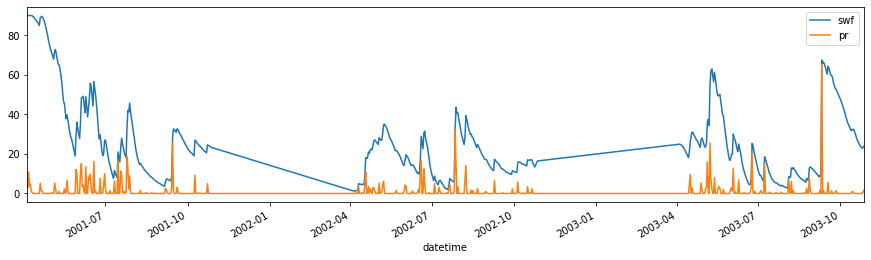

In [62]:
results.plot(y = ['swf', 'pr'], figsize=(15, 4))